In [1]:
%pylab inline

import numpy as np
import pickle
import matplotlib.pyplot as pl
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

Populating the interactive namespace from numpy and matplotlib


In [2]:
# importing data
#
data_trunc = np.load('../../data/KeplerSampleWErr.npy')
data_trunc_sparse = np.load('../../data/KeplerSampleWErrSparse.npy')
#data_full = np.load('../../data/KeplerSampleFullQ.npy') # NOT ABLE TO IMPORT (!)

# with open('../../data/KeplerSampleFullQ.pkl','rb') as f:
#     u = pickle._Unpickler(f)
#     u.encoding = 'latin1'
#     data_full = u.load()

In [3]:
# make train/test splits
#
print("data_trunc.shape: {}".format(data_trunc.shape))
print("data_trunc_sparse.shape: {}".format(data_trunc_sparse.shape))

data_trunc_train = data_trunc[2000:]
data_trunc_test = data_trunc[:2000]

print("data_trunc_train.shape: {}".format(data_trunc_train.shape))
print("data_trunc_test.shape: {}".format(data_trunc_test.shape))

data_trunc_sparse_train = data_trunc_sparse[2000:]
data_trunc_sparse_test = data_trunc_sparse[:2000]

print("data_trunc_sparse_train.shape: {}".format(data_trunc_sparse_train.shape))
print("data_trunc_sparse_test.shape: {}".format(data_trunc_sparse_test.shape))

data_trunc.shape: (2500, 3, 100)
data_trunc_sparse.shape: (2500, 3, 50)
data_trunc_train.shape: (500, 3, 100)
data_trunc_test.shape: (2000, 3, 100)
data_trunc_sparse_train.shape: (500, 3, 50)
data_trunc_sparse_test.shape: (2000, 3, 50)


In [4]:
#
# SUBROUTINES!!

rng = np.random.RandomState(0)
outliers_fraction = 0.01 # needed by OneClassSVM and IsolationForest

# trains and runs isolation forest, OneClassSVM and Elliptic Envelope
#

def train_and_run_models(train, test):
    
    train_flux = train[:,1,:]
    test_flux = test[:,1,:]

    # Isolation Forest
    #
    clf_iso = IsolationForest(max_samples=train_flux.shape[0], contamination=outliers_fraction, random_state=rng)
    clf_iso.fit(train_flux)
    scores_iso = clf_iso.decision_function(test_flux)
    
    # OneClassSVM
    #
    clf_svm = svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05, kernel="rbf", gamma=0.1)
    clf_svm.fit(train_flux)
    scores_svm = clf_svm.decision_function(test_flux)
    
    # Robust Covariance
    #    
    clf_elp = EllipticEnvelope(contamination=outliers_fraction)
    clf_elp.fit(train_flux)
    scores_elp = clf_elp.decision_function(test_flux)
    
    return (scores_iso, scores_svm, scores_elp)

# plots three light curves in a subfigure
#

def plot_three_across(examples, dat):
    
    for i, ex in enumerate(examples):
        
        if i % 3 == 0:
            f, (ax0, ax1, ax2) = pl.subplots(1, 3, figsize=(18, 6))
            ax = ax0
        elif i % 3 == 1:
            ax = ax1
        else:
            ax = ax2
            
        ax.errorbar(dat[ex,0,:], dat[ex,1,:], dat[ex,2,:])
        ax.set_title(ex)

        
        if i % 3 == 2: pl.show()

# plots three light curves in a subfigure
#

def plot_three_results_across(ex0, ex1, ex2, dat):
    
    for i in range(len(ex0)):
        
        if i == 10:
            break
        
        f, (ax0, ax1, ax2) = pl.subplots(1, 3, figsize=(18, 6))
        ax0.errorbar(dat[ex0[i],0,:], dat[ex0[i],1,:], dat[ex0[i],2,:])
        ax0.set_title(ex0[i])
        ax1.errorbar(dat[ex1[i],0,:], dat[ex1[i],1,:], dat[ex1[i],2,:])
        ax1.set_title(ex1[i])
        ax2.errorbar(dat[ex2[i],0,:], dat[ex2[i],1,:], dat[ex2[i],2,:])
        ax2.set_title(ex2[i])
        pl.show()
        
def find_overlap(ex0, ex1, ex2, topk):
    return list(set(ex0[:topk]) & set(ex1[:topk]) & set(ex2[:topk]))

# Compare on Truncated Dense Data

In [5]:
# 
# 

(scores_trunc_iso, scores_trunc_svm, scores_trunc_elp) = train_and_run_models(data_trunc_train, data_trunc_test)

def sort_by_index(alist):
    return sorted(range(len(alist)), key=lambda k: alist[k])

outliers_trunc_iso = sort_by_index(scores_trunc_iso)
outliers_trunc_svm = sort_by_index(scores_trunc_svm)
outliers_trunc_elp = sort_by_index(scores_trunc_elp)




## Overlap of Top 20 Outliers

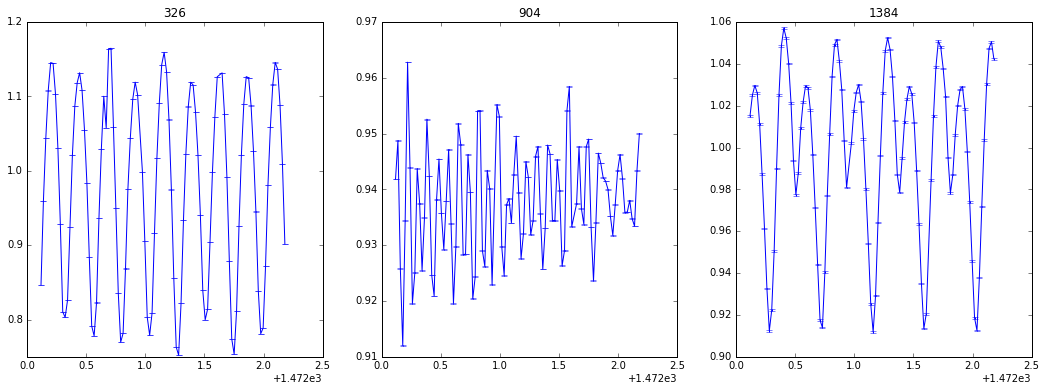

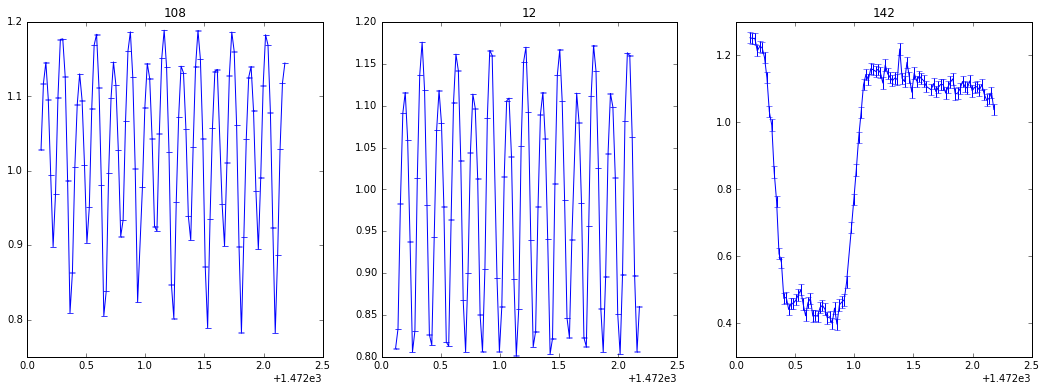

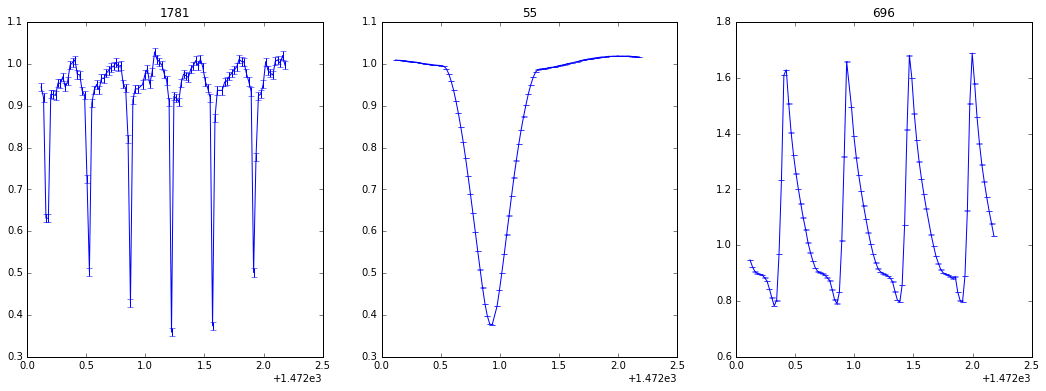

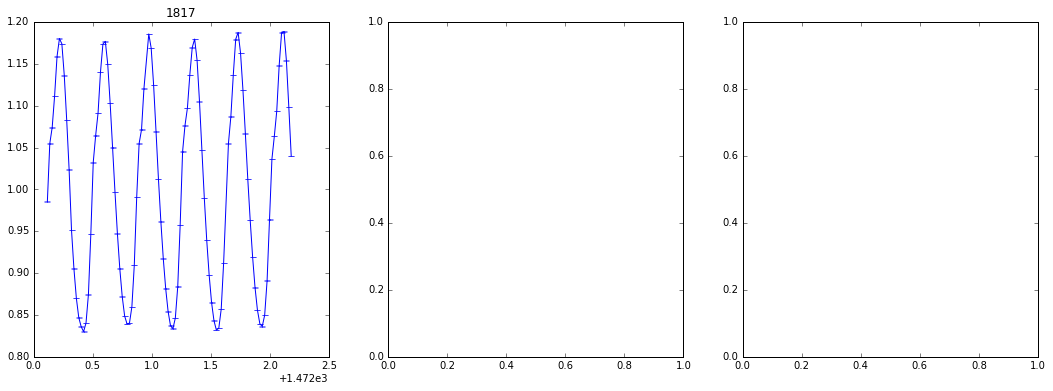

In [6]:
overlap_top20 = find_overlap(outliers_trunc_iso, outliers_trunc_svm, outliers_trunc_elp, 20)

plot_three_across(overlap_top20, data_trunc)

## Plotting the Top 20 Outliers of Each

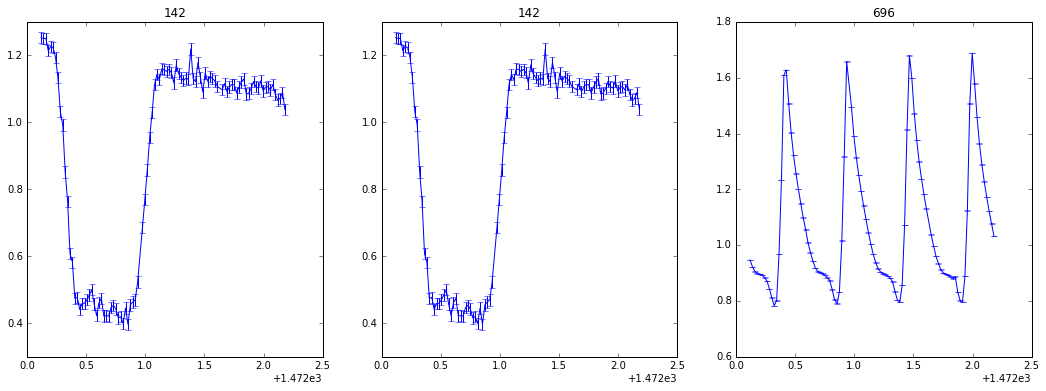

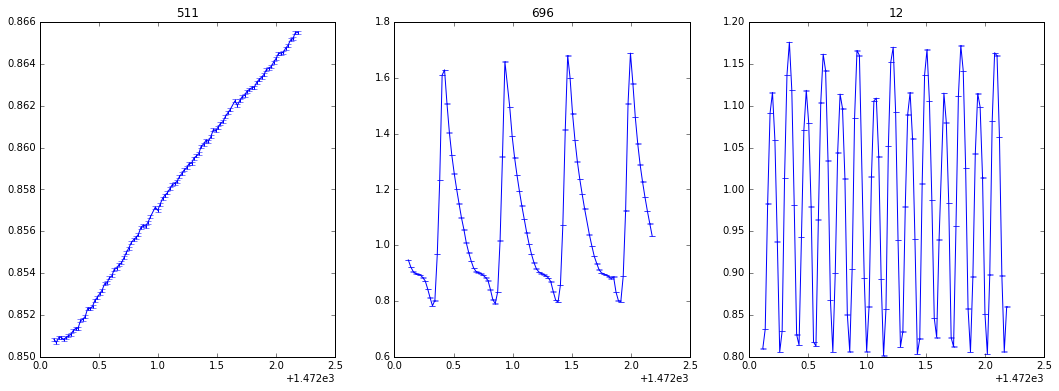

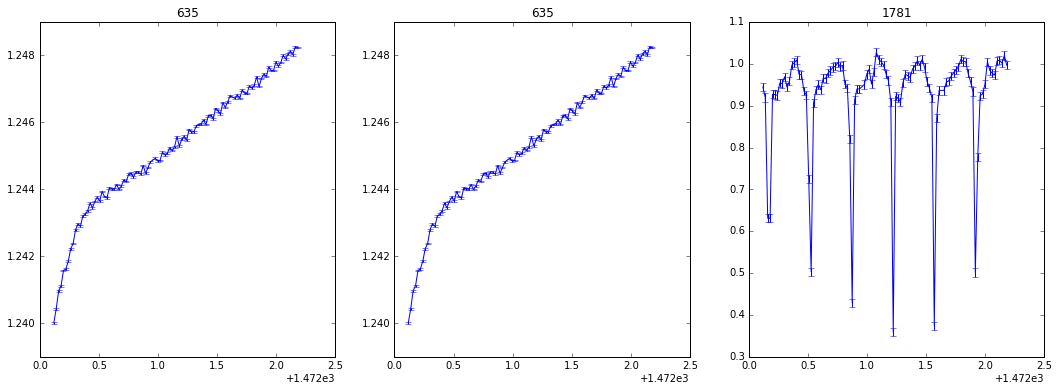

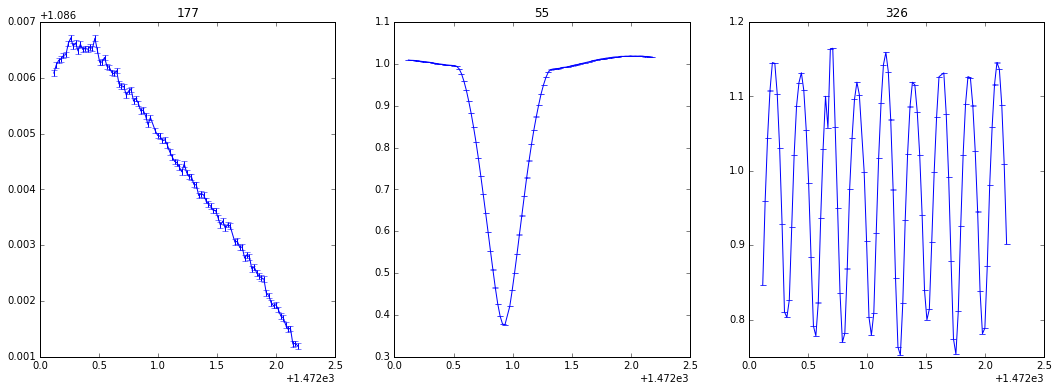

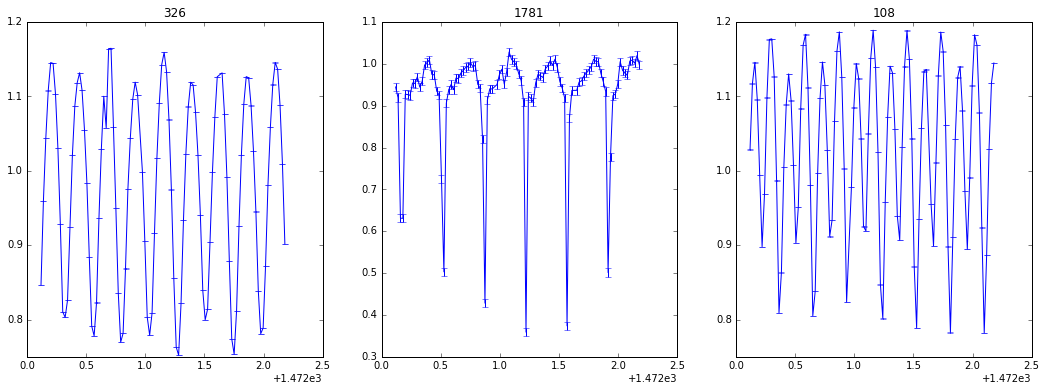

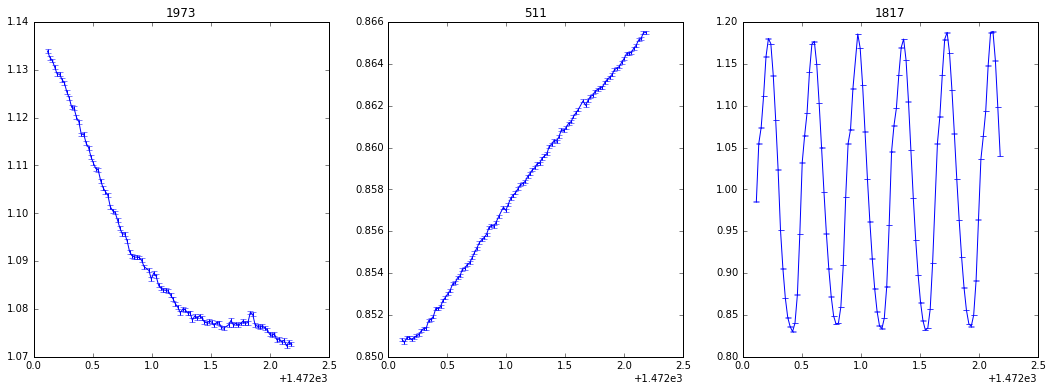

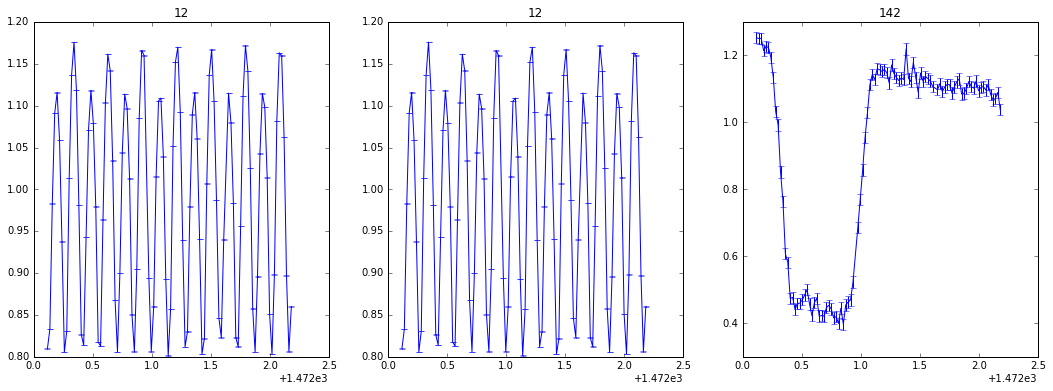

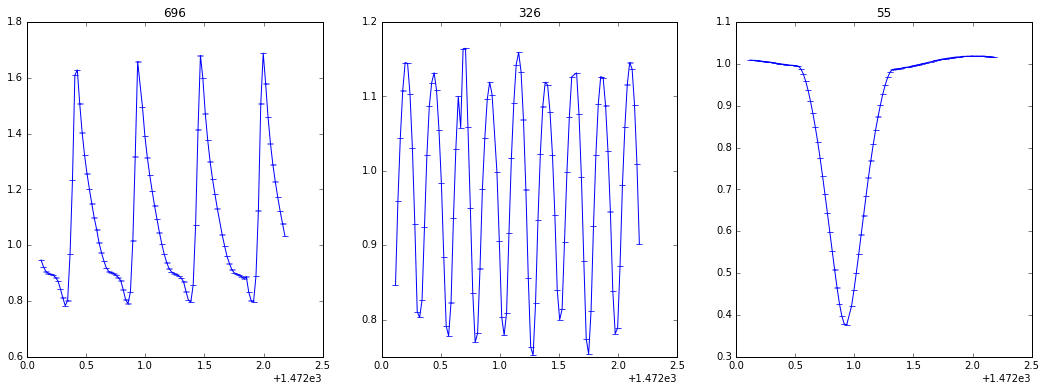

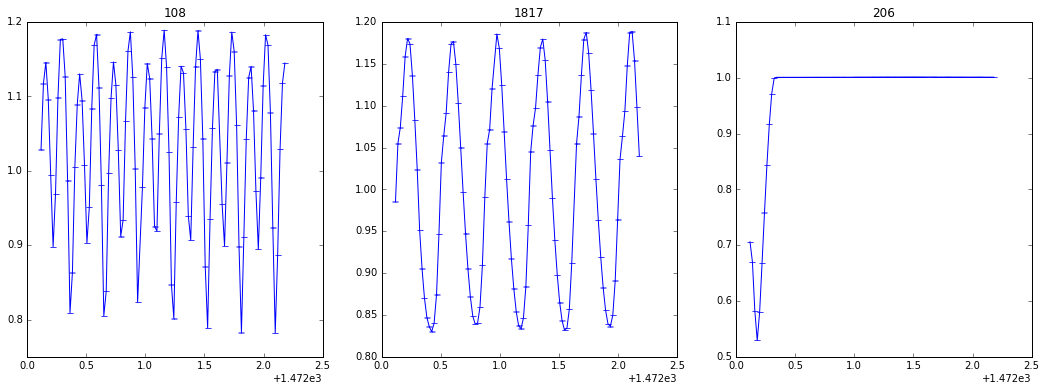

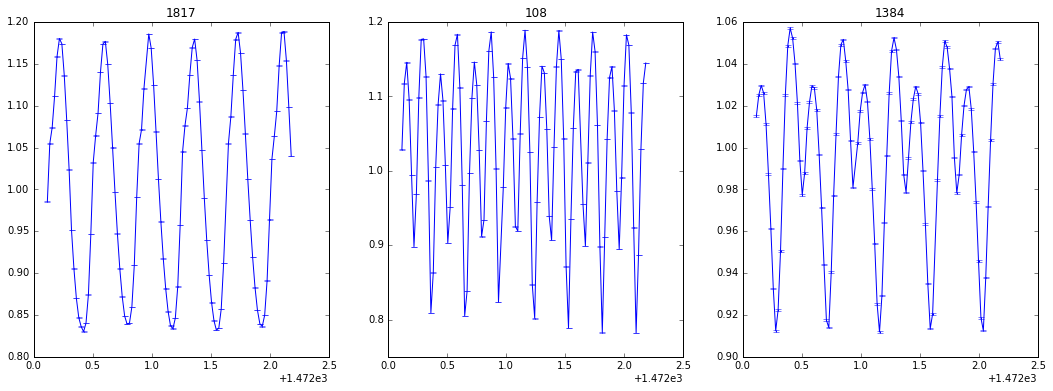

In [7]:
plot_three_results_across(outliers_trunc_iso, outliers_trunc_svm, outliers_trunc_elp, data_trunc_test)